In [9]:
pip install fastdtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp39-cp39-linux_x86_64.whl size=534329 sha256=47cfc24ccfbc24fb2c5851f4cc2cab6e0080ca4d32420928e390eebde02cf3da
  Stored in directory: /root/.cache/pip/wheels/1f/a1/63/bfd0fddb5bf0b59f564872e29272cee8a2de0cd745d88fede5
Successfully built fastdtw


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
from scipy.signal import savgol_filter

In [34]:
def delete_random_points(number_points, number_list):
  for i in range(0, number_points):
    index_to_delete = random.randint(0, len(number_list) - 1)
    number_list.pop(index_to_delete)
  return number_list

def interpolate(x, n_points= 10000000):
  x = np.array(x) 
  x_interp = np.interp(np.linspace(0, len(x) - 1, n_points), np.arange(len(x)), x)
  return x_interp  

def dtw_error(x1, y1, x2, y2):
    distance, path = fastdtw(list(zip(x1, y1)), list(zip(x2, y2)))
    error = []
    for i in range(len(path)):
        point1 = (x1[path[i][0]], y1[path[i][0]])
        point2 = (x2[path[i][1]], y2[path[i][1]])
        error.append(euclidean(point1, point2))

    return error

def dtw_error_theta(theta1, theta2):
    distance, path = fastdtw(list(zip(theta1)), list(zip(theta2)))
    error = []
    for i in range(len(path)):
        error.append(theta1[path[i][0]] - theta2[path[i][1]])
    return error
   
def get_circle_poins(radius = 1, initial_theta = 0,  points_numbler = 1000):  
    d_theta = 360/points_numbler
    theta = initial_theta
    circle_x = []
    circle_y = []

    for i in range(0, points_numbler):
      theta_rad = (np.pi*theta)/180
      x = radius*np.cos(theta_rad)
      y = radius*np.sin(theta_rad)
      circle_x.append(x)
      circle_y.append(y)
      theta += d_theta

    return circle_x, circle_y 

def get_circle_orientation_robot(radius = 1, initial_theta = 0,  points_numbler = 1000):  
    d_theta = 360/points_numbler
    theta = initial_theta
    orientation_robot = [theta+90]

    for i in range(0, points_numbler):
      theta += d_theta
      orientation_robot.append(theta+90)


    return orientation_robot   


In [35]:
data_id = 32
df = pd.read_csv(f'data{data_id}.csv')

limit_min = 0

x_gt, y_gt = get_circle_poins(radius = 1, 
                              initial_theta = 280,  
                              points_numbler = 612)

x_ekf = eval(df['ekf'][0])[limit_min:]
y_ekf = eval(df['ekf'][1])[limit_min:]

x_amcl = eval(df['amcl'][0])[limit_min:]
y_amcl = eval(df['amcl'][1])[limit_min:]

x_reconstruction = eval(df['reconstruction'][0])[limit_min:]
y_reconstruction = eval(df['reconstruction'][1])[limit_min:]

print(f'ekf  len: {len(x_ekf)}')
print(f'amcl len: {len(x_amcl)}')
print(f'rec  len: {len(x_reconstruction)}')

ekf  len: 612
amcl len: 104
rec  len: 495


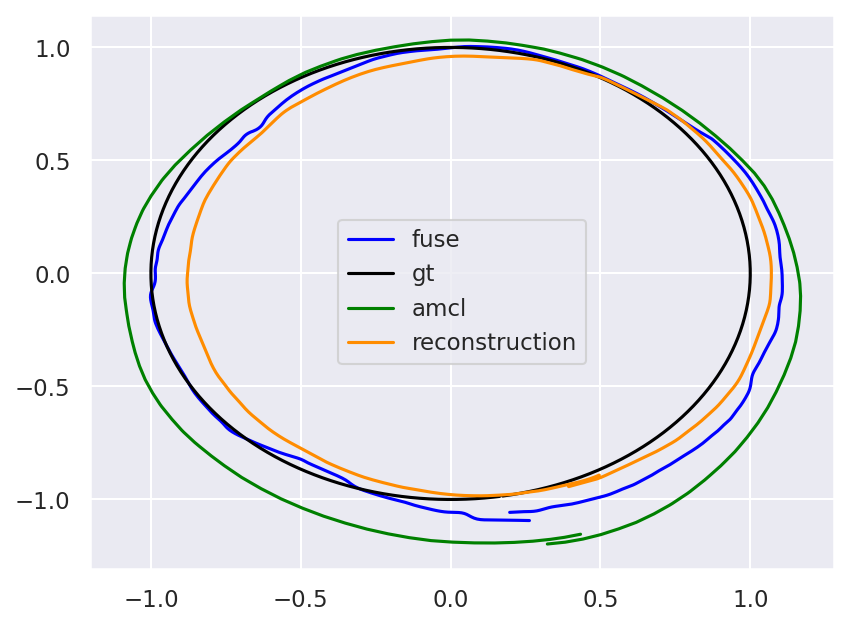

In [46]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
# plt.xlim(-2, 2)
# plt.ylim(-1.5, 1.5)
sns.set()
linestyle = 'dashed'

x_reconstruction = savgol_filter(x_reconstruction, window_length=9, polyorder=2)
y_reconstruction = savgol_filter(y_reconstruction, window_length=9, polyorder=2)
x_ekf = savgol_filter(x_ekf, window_length=9, polyorder=2)
y_ekf = savgol_filter(y_ekf, window_length=9, polyorder=2)


# plt.plot(x_ekf[0], y_ekf[0], 'o', color="blue",  label='fuse')
# plt.plot(x_gt[0], y_gt[0], 'o', color="black", label='gt')
# plt.plot(x_amcl[0], y_amcl[0], 'o', color="green", label='amcl')
# plt.plot(x_reconstruction[0], y_reconstruction[0], 'o', color="darkorange",  label='reconstruction')

plt.plot(x_ekf, y_ekf, color="blue",  label='fuse')
plt.plot(x_gt, y_gt, color="black", label='gt')
plt.plot(x_amcl, y_amcl, color="green", label='amcl')
plt.plot(x_reconstruction, y_reconstruction, color="darkorange",  label='reconstruction')

plt.legend()
plt.show()

In [37]:
x_ekf = savgol_filter(x_ekf, window_length=9, polyorder=2)
y_ekf = savgol_filter(y_ekf, window_length=9, polyorder=2)

x_amcl = savgol_filter(x_amcl, window_length=9, polyorder=2)
y_amcl = savgol_filter(y_amcl, window_length=9, polyorder=2)
 
x_reconstruction = savgol_filter(x_reconstruction, window_length=9, polyorder=2)
y_reconstruction = savgol_filter(y_reconstruction, window_length=9, polyorder=2)

x_amcl = interpolate(x_amcl, n_points=612)
y_amcl = interpolate(y_amcl, n_points=612)

x_reconstruction = interpolate(x_reconstruction, n_points=612)
y_reconstruction = interpolate(y_reconstruction, n_points=612)

#error_ekf = np.sqrt((x_gt - np.array(x_ekf))**2 + (y_gt - np.array(y_ekf))**2) 
error_amcl = dtw_error(x_gt, y_gt, x_amcl, y_amcl)
error_rec = dtw_error(x_gt, y_gt, x_reconstruction, y_reconstruction)
error_ekf = dtw_error(x_gt, y_gt, x_ekf, y_ekf)

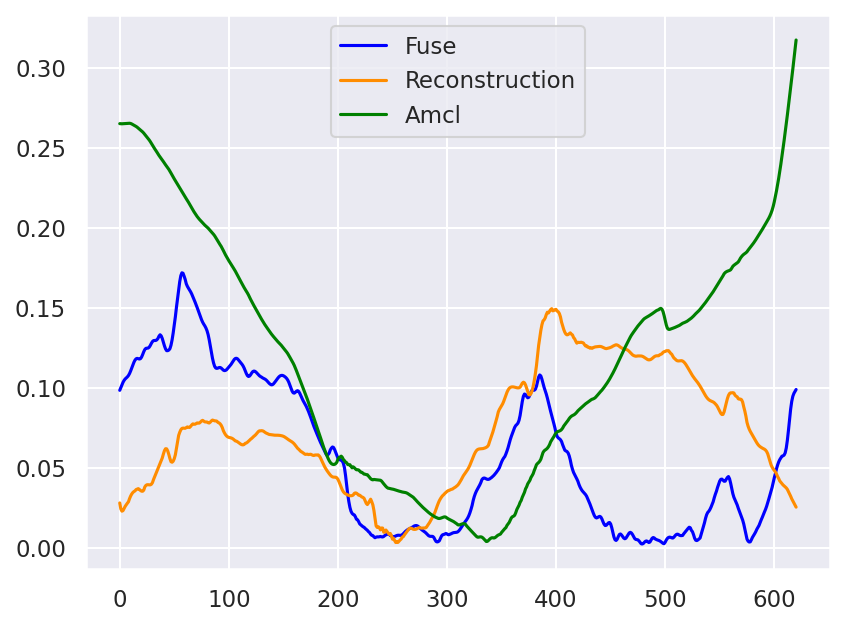

In [38]:
len_min_error = min([len(error_ekf), len(error_amcl), len(error_rec)])
error_ekf = savgol_filter(error_ekf, window_length=9, polyorder=2)
error_rec = savgol_filter(error_rec, window_length=9, polyorder=2)
error_amcl = savgol_filter(error_amcl, window_length=9, polyorder=2)

plt.plot(error_ekf[20:len_min_error], color='blue', label = 'Fuse')
plt.plot(error_rec[20:len_min_error], color='darkorange', label = 'Reconstruction')
plt.plot(error_amcl[20:len_min_error], color='green', label = 'Amcl')
plt.legend()
plt.show()

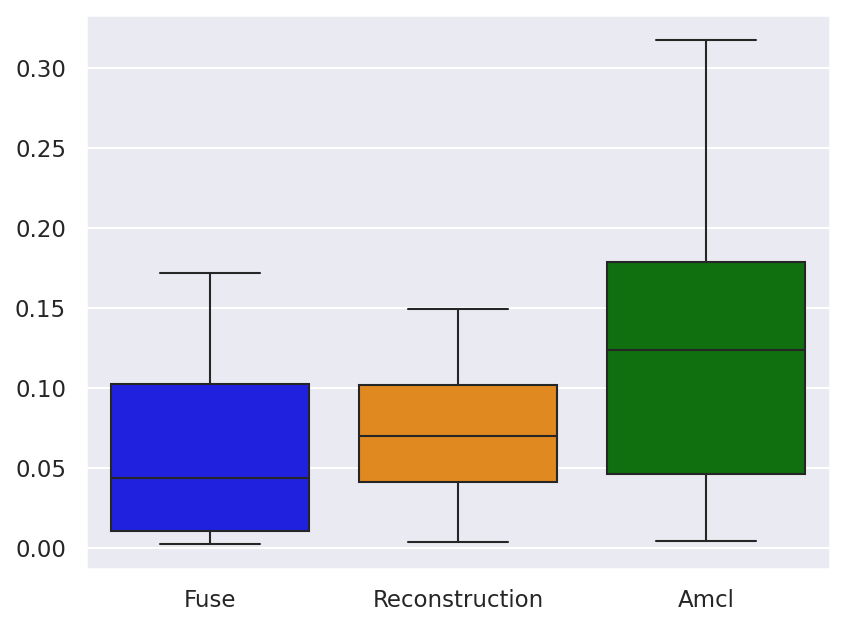

In [16]:
fig, ax = plt.subplots()

d = {'Fuse': error_ekf[20:len_min_error], 
     'Reconstruction': error_rec[20:len_min_error],
     'Amcl': error_amcl[20:len_min_error]}

d = pd.DataFrame(data=d)


my_pal = {"Fuse": "blue", "Reconstruction": "darkorange", "Amcl": "green"}

ax = sns.boxplot( data=d , linewidth=1, palette = my_pal)


plt.show()

In [42]:
data_id = 32
df = pd.read_csv(f'data{data_id}.csv')

limit_min = 0

orientation_gt = get_circle_orientation_robot(radius = 1, 
                              initial_theta = 280,  
                              points_numbler = 494)

theta_ekf = eval(df['ekf'][2])[limit_min:]

theta_amcl = eval(df['amcl'][2])[limit_min:]

theta_reconstruction = eval(df['reconstruction'][2])[limit_min:]

print(f'ekf  len: {len(theta_ekf)}')
print(f'amcl len: {len(theta_amcl)}')
print(f'rec  len: {len(theta_reconstruction)}')


theta_reconstruction = np.array(theta_reconstruction)
orientation_gt = np.array(orientation_gt)*np.pi/180

ekf  len: 612
amcl len: 104
rec  len: 495


In [43]:
theta_reconstruction = np.arccos(
                              np.cos(theta_reconstruction)
                              )*180/np.pi
orientation_gt = np.arccos(
                            np.cos(orientation_gt)
                            )*180/np.pi 

orientation_gt - theta_reconstruction
#theta_error = dtw_error_theta(orientation_gt, theta_reconstruction)

array([-11.91345813, -12.89204875, -13.69776557, -13.82183976,
       -15.24991829, -14.69844238, -15.55518925, -14.83231486,
       -14.78159255, -13.85049643, -13.13766925, -12.58219255,
       -14.31835359, -13.32785873, -13.61705445, -12.52653488,
       -11.86059695, -12.80422041,  -9.71361996, -11.03610377,
       -11.35078293,  -9.61516907, -10.56110797,  -8.169492  ,
        -5.78773541,  -9.72970947,  -9.65841805,  -8.93785226,
        -9.32189882, -10.94326829, -10.87470895,  -9.50377255,
        -9.44649668, -11.20207254,  -9.18991798,  -9.77225517,
       -10.24858783, -10.72020082,  -8.84899746, -10.55573747,
       -10.4316965 , -10.75668924, -10.04871832, -11.19157499,
        -9.86066691, -10.42198761, -10.05631845,  -9.02338763,
        -9.54044529, -10.12731772, -10.3073397 ,  -8.06856288,
        -9.24768785,  -8.54409167,  -8.69403349,  -9.25567521,
        -9.16657065,  -9.55467093,  -6.91860932,  -8.26942476,
        -8.74180274,  -9.31388098,  -9.17776424,  -9.71